In [1]:
import pandas as pd # for data processing
import seaborn as sns # for graphs
import matplotlib.pyplot as plt # for plotting 
import numpy as np # for linear algebra
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Read csv file using pandas
df = pd.read_csv('sales_data_sample.csv',encoding = 'latin1', lineterminator = '\n')

In [3]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [4]:
def wrangle(path):
    df = pd.read_csv(path, encoding = 'latin1')
    df.dropna(axis=1, inplace=True)
    df = df[['QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER','SALES','ORDERDATE','PRODUCTLINE','MSRP','COUNTRY','DEALSIZE']]
    df['sale_year'] = df['ORDERDATE'].dt.year
    df['sale_month'] = df['ORDERDATE'].dt.month
    df['sale_day'] = df['ORDERDATE'].dt.day
    df.drop('ORDERDATE', axis=1, inplace=True)
    return df

In [5]:
#basic details and information
df.info()
df.columns
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [6]:
#removing the columns which are not requied
df.dropna(axis=1,inplace=True)

#take only usefull columns
df_saling_record = df[['QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER','SALES','ORDERDATE','PRODUCTLINE','MSRP','COUNTRY','DEALSIZE']]
df_saling_record.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,PRODUCTLINE,MSRP,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2/24/2003 0:00,Motorcycles,95,USA,Small
1,34,81.35,5,2765.90,5/7/2003 0:00,Motorcycles,95,France,Small
2,41,94.74,2,3884.34,7/1/2003 0:00,Motorcycles,95,France,Medium
3,45,83.26,6,3746.70,8/25/2003 0:00,Motorcycles,95,USA,Medium
4,49,100.00,14,5205.27,10/10/2003 0:00,Motorcycles,95,USA,Medium


In [7]:
df_saling_record['PRODUCTLINE'].value_counts()

PRODUCTLINE
Classic Cars        967
Vintage Cars        607
Motorcycles         331
Planes              306
Trucks and Buses    301
Ships               234
Trains               77
Name: count, dtype: int64

In [8]:
# conversion of ORDERDATE
df_saling_record['ORDERDATE'] = pd.to_datetime(df_saling_record['ORDERDATE'])
df_saling_record.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,PRODUCTLINE,MSRP,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Motorcycles,95,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Motorcycles,95,France,Small
2,41,94.74,2,3884.34,2003-07-01,Motorcycles,95,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Motorcycles,95,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Motorcycles,95,USA,Medium


# Sales Distribution

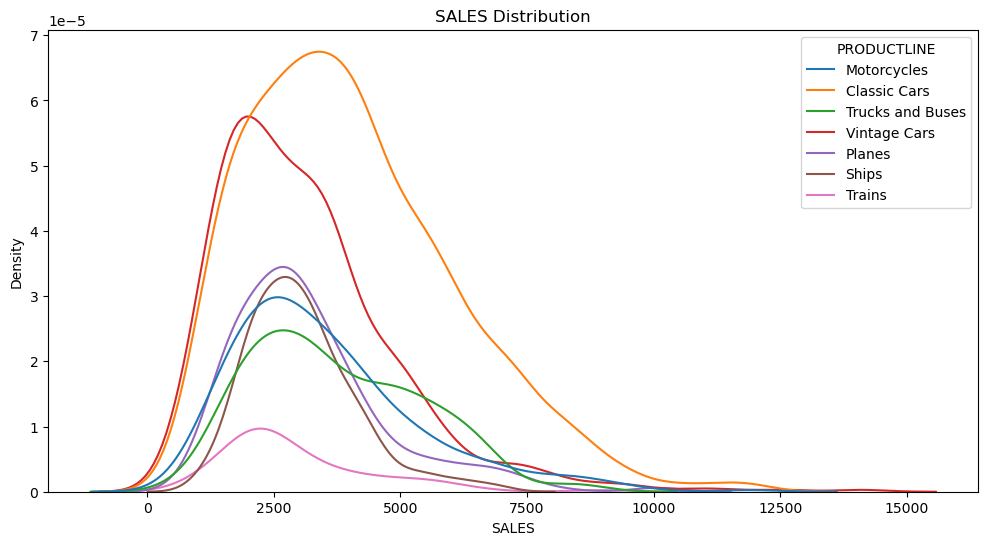

In [9]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=df_saling_record, x='SALES', hue='PRODUCTLINE')
plt.title('SALES Distribution')
plt.show()

In [10]:
################################

# extract time based features

In [11]:
df_saling_record['sale_year'] = df_saling_record['ORDERDATE'].dt.year
df_saling_record['sale_month'] = df_saling_record['ORDERDATE'].dt.month
df_saling_record['sale_day'] = df_saling_record['ORDERDATE'].dt.day
df_saling_record.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,PRODUCTLINE,MSRP,COUNTRY,DEALSIZE,sale_year,sale_month,sale_day
0,30,95.70,2,2871.00,2003-02-24,Motorcycles,95,USA,Small,2003,2,24
1,34,81.35,5,2765.90,2003-05-07,Motorcycles,95,France,Small,2003,5,7
2,41,94.74,2,3884.34,2003-07-01,Motorcycles,95,France,Medium,2003,7,1
3,45,83.26,6,3746.70,2003-08-25,Motorcycles,95,USA,Medium,2003,8,25
4,49,100.00,14,5205.27,2003-10-10,Motorcycles,95,USA,Medium,2003,10,10


# Yearly, Monthly, Daily Sales Distribution

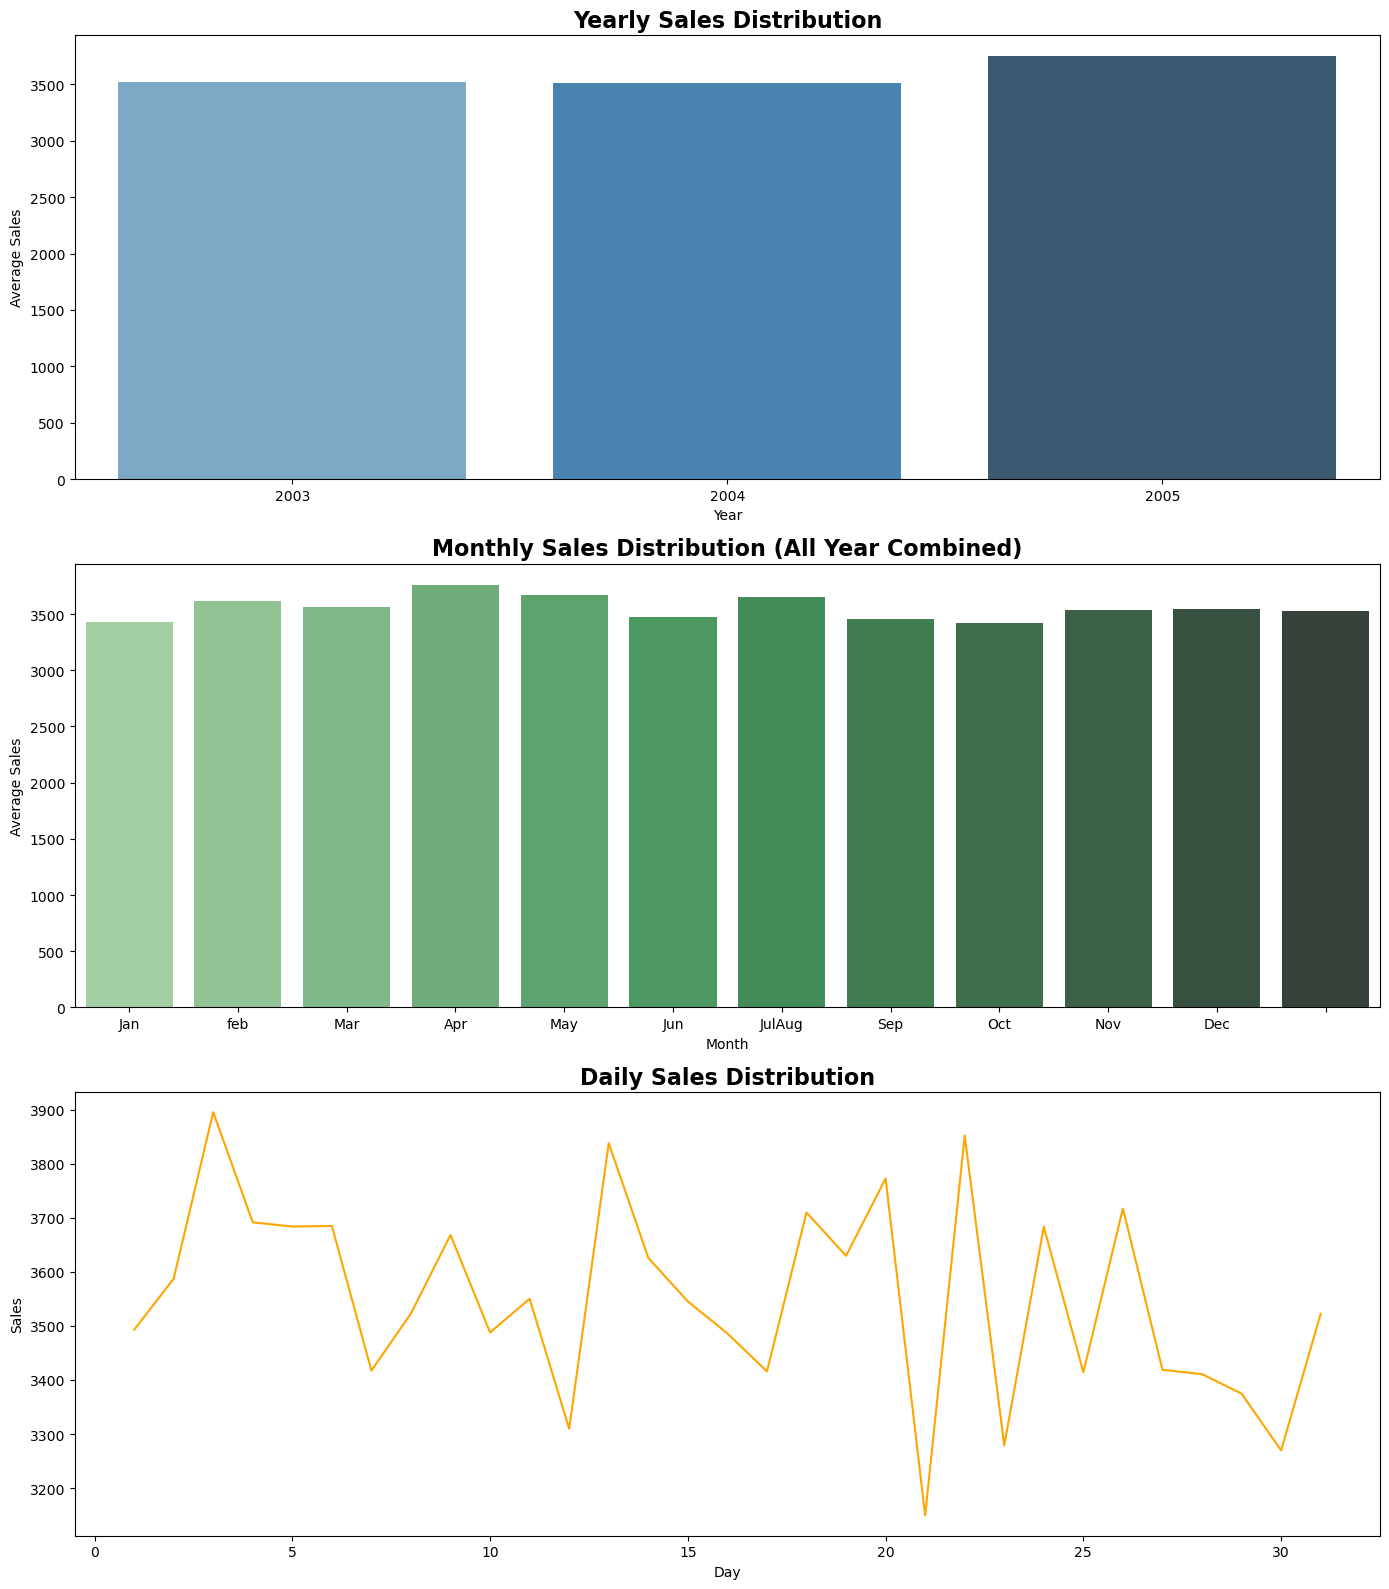

In [12]:
#Yearly
yearly_sales = df_saling_record.groupby(df_saling_record['sale_year'])['SALES'].mean().reset_index()
yearly_sales.columns = ['YEAR','AVG_SALES']

#monthly
monthly_sales = df_saling_record.groupby(df_saling_record['sale_month'])['SALES'].mean().reset_index()
monthly_sales.columns = ['MONTH','AVG_SALES']

#daily
daily_sales = df_saling_record.groupby(df_saling_record['sale_day'])['SALES'].mean().reset_index()
daily_sales.columns = ['DAY','AVG_SALES']

#set up dashboard layout
fig, axes = plt.subplots(3, 1, figsize=(14, 16), tight_layout=True)

#Yearly sales plot
sns.barplot(ax=axes[0], data=yearly_sales, x='YEAR', y='AVG_SALES', palette='Blues_d')
axes[0].set_title('Yearly Sales Distribution',fontsize=16, weight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Sales')

#monthly sales plot
sns.barplot(ax=axes[1], data=monthly_sales, x='MONTH', y='AVG_SALES', palette='Greens_d')
axes[1].set_title('Monthly Sales Distribution (All Year Combined)',fontsize=16, weight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Sales')
axes[1].set_xticklabels(['Jan', 'feb', 'Mar', 'Apr', 'May', 'Jun','Jul' 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

#daily sales plot
sns.lineplot(ax=axes[2], data=daily_sales, x='DAY', y='AVG_SALES', color='orange')
axes[2].set_title('Daily Sales Distribution',fontsize=16, weight='bold')
axes[2].set_xlabel('Day')
axes[2].set_ylabel('Sales')

plt.show()
            

# Yearly Sales Forcasting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


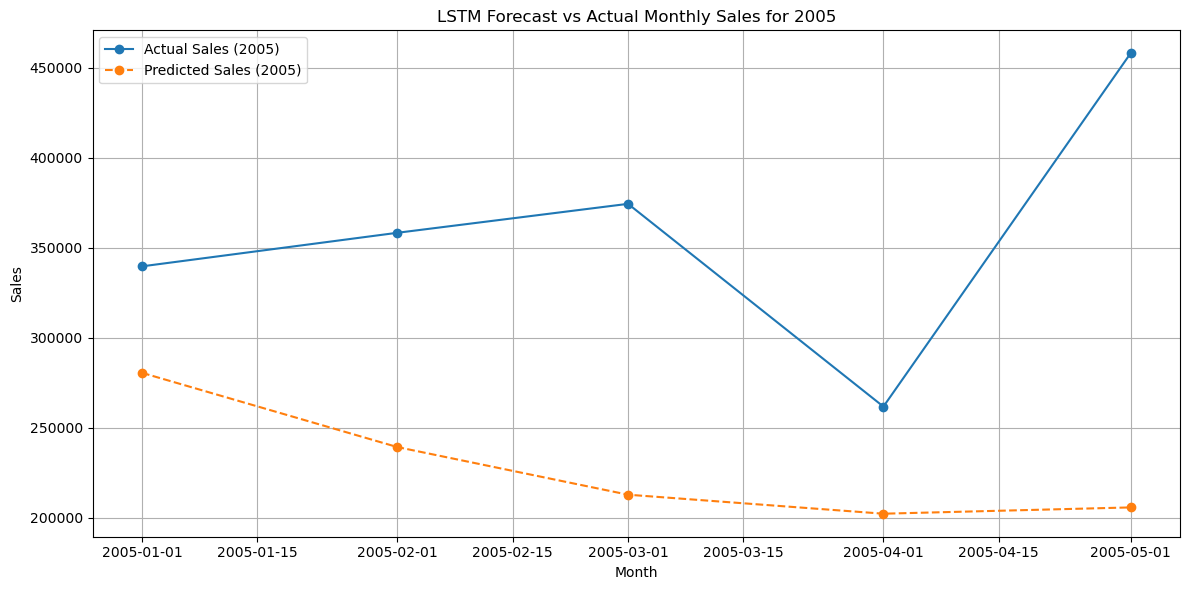

In [13]:
# extract Yearmonth
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['YearMonth'] = df['ORDERDATE'].dt.to_period('M').astype(str)

# Aggregate monthly sales
monthly_sales = df.groupby('YearMonth')['SALES'].sum().reset_index()
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales['YearMonth'])

# Sort the data
monthly_sales = monthly_sales.sort_values('YearMonth').reset_index(drop=True)

# Scale sales
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(monthly_sales[['SALES']])

# Create LSTM sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)
seq_length = 12
X, y = create_sequences(sales_scaled, seq_length)

# Split: train = 2003–2004, test = 2005
split_index = monthly_sales[monthly_sales['YearMonth'].dt.year == 2005].index.min() - seq_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

# Build the LSTM model
model = Sequential([LSTM(50, activation='relu', input_shape=(seq_length, 1)),Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=1000, verbose=0)

# Predict on test
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# Prepare results for plotting
predicted_dates = monthly_sales['YearMonth'][seq_length + split_index:seq_length + split_index + len(y_pred)]
forecast_df = pd.DataFrame({'Date': predicted_dates, 'Actual': y_actual.flatten(), 'Predicted': y_pred.flatten()})

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Actual'], marker='o', label='Actual Sales (2005)')
plt.plot(forecast_df['Date'], forecast_df['Predicted'], marker='o', linestyle='--', label='Predicted Sales (2005)')
plt.title('LSTM Forecast vs Actual Monthly Sales for 2005')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Daily Sales Import

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Prepare Data (make sure 'ORDERDATE' is datetime and 'SALES' exists)
df_saling_record['ORDERDATE'] = pd.to_datetime(df_saling_record['ORDERDATE'])

# 2. Aggregate daily sales
daily_sales = df_saling_record.groupby('ORDERDATE')['SALES'].sum().reset_index()
daily_sales = daily_sales.sort_values('ORDERDATE')

# 3. Normalize sales values
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(daily_sales[['SALES']])

# 4. Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)
seq_length = 30 # use past 30 days to predict the next
X, y = create_sequences(sales_scaled, seq_length)

# 5. Train/test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# 6. Build and train LSTM model
model = Sequential([LSTM(50, activation='relu', input_shape=(seq_length, 1)), Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0881
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0621 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0466 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0385 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0375 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0369 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0380 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0395 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0384 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0393 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0402 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0369 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0400
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0382 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0381 
Epoch 16/100
6/6 ━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


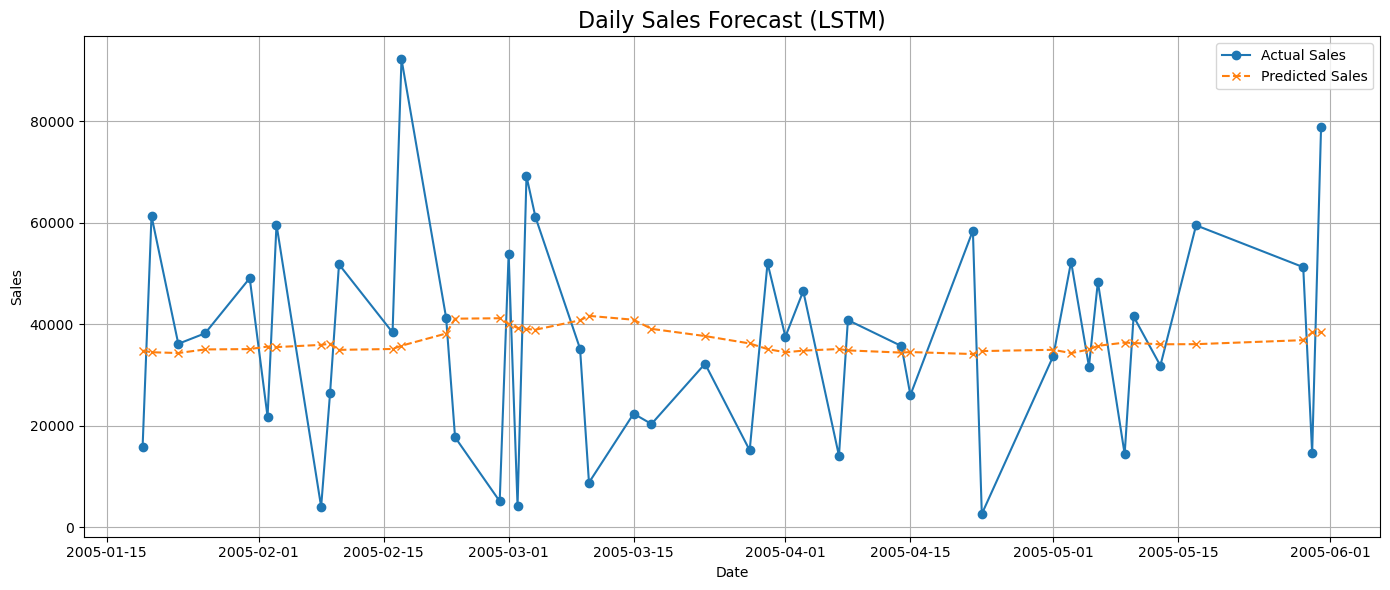

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Forecasted sales for the next day: 39308.69


In [15]:
# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# 8. Prepare DataFrame for plotting
predict_dates = daily_sales['ORDERDATE'][seq_length + split:seq_length + split + len(y_pred)]
forecast_df = pd.DataFrame({'Date': predict_dates, 'Actual': y_actual.flatten(), 'Predicted': y_pred.flatten()})

# 9. Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual Sales', marker='o')
plt.plot(forecast_df['Date'], forecast_df['Predicted'], label='Predicted Sales', marker='x', linestyle='--')
plt.title('Daily Sales Forecast (LSTM)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# 10. Forecast next day sales
last_seq = sales_scaled[-seq_length:]
last_seq = last_seq.reshape((1, seq_length, 1))
next_day_scaled = model.predict(last_seq)
next_day_sales = scaler.inverse_transform(next_day_scaled)
print("Forecasted sales for the next day:", round(next_day_sales[0][0], 2))